In [166]:
import geopandas as gpd
import pandas as pd
#import concurrent.futures
#import fiona
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
#from shapely.geometry import Point
#from shapely.geometry import shape
#from shapely.geometry import box
#from shapely.ops import unary_union
from tqdm import tqdm
from scipy.spatial import cKDTree
#from rasterio.warp import calculate_default_transform, reproject, Resampling
#from rasterio.plot import show
#from rasterio.features import shapes
#from rasterio.mask import mask
#import rasterio
import numpy as np
import yaml
import os
#import seaborn as sns
#from pyproj import CRS


# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)



##### Find the weighted average distance to nearest dam for all AEI
Load, Reproject, Save Dam data

        Country     Purpose  ISO  Long__res_  Lat__res_  index_righ   FID  \
0  Burkina Faso  Irrigation  BFA   -5.356683  10.590938        1237  1237   
1  South Africa  Irrigation  ZAF   22.585419 -33.512207        4632  4632   
2       Morocco  Irrigation  MAR   -5.492708  35.568075         441   441   
3  South Africa  Irrigation  ZAF   24.617143 -33.745313        4632  4632   
4       Algeria  Irrigation  DZA    0.047035  35.521177         304   304   

                           geometry  
0   POINT (-596303.224 1185749.700)  
1  POINT (2514197.342 -3963489.904)  
2   POINT (-611445.458 4241350.764)  
3  POINT (2740367.824 -3994654.838)  
4      POINT (5235.912 4234934.518)  


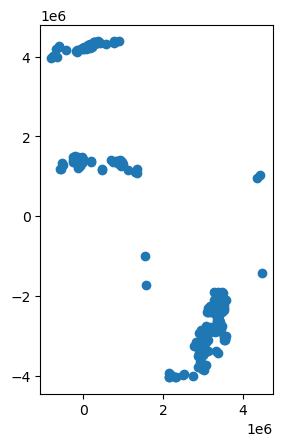

        Country     Purpose  ISO  Long__res_  Lat__res_  index_righ   FID  \
0       Algeria  Irrigation  DZA    5.923963  34.853860         679   679   
1  South Africa  Irrigation  ZAF   20.405208 -33.393856        3180  3180   
2  South Africa  Irrigation  ZAF   20.371980 -33.860692        3180  3180   
3       Morocco  Irrigation  MAR   -4.461314  31.995304         679   679   
4       Namibia  Irrigation  NAM   17.940090 -26.931431        3180  3180   

                           geometry  
0    POINT (659452.545 4144038.994)  
1  POINT (2271497.364 -3947699.209)  
2  POINT (2267798.440 -4010111.669)  
3   POINT (-496631.203 3762694.220)  
4  POINT (1997081.684 -3114907.567)  


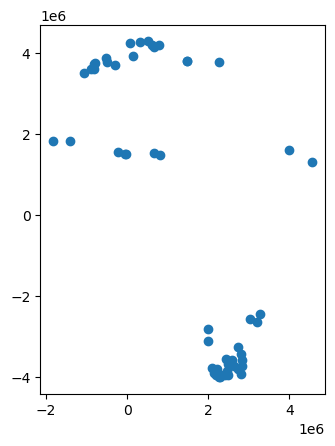

  Country     Purpose  ISO  Long__res_  Lat__res_  index_righ   FID  \
0   Egypt  Irrigation  EGY   31.189583  27.202083        1521  1521   
1   Egypt  Irrigation  EGY   30.454033  29.230288        1521  1521   
2   Egypt  Irrigation  EGY   30.397917  29.181250        1521  1521   

                          geometry  
0  POINT (3472008.498 3148742.115)  
1  POINT (3390127.446 3404989.316)  
2  POINT (3383880.642 3398735.387)  


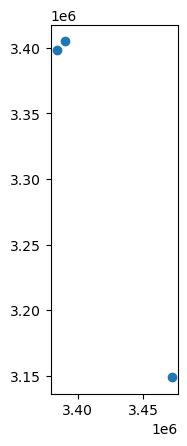

        Country     Purpose  ISO  Long__res_  Lat__res_  index_righ   FID  \
0         Egypt  Irrigation  EGY   31.189583  27.202083        2466  2466   
1       Algeria  Irrigation  DZA    5.923963  34.853860        2466  2466   
2  South Africa  Irrigation  ZAF   20.405208 -33.393856        3566  3566   
3  Burkina Faso  Irrigation  BFA   -5.356683  10.590938        1462  1462   
4  South Africa  Irrigation  ZAF   22.585419 -33.512207        3566  3566   

                           geometry  
0   POINT (3472008.498 3148742.115)  
1    POINT (659452.545 4144038.994)  
2  POINT (2271497.364 -3947699.209)  
3   POINT (-596303.224 1185749.700)  
4  POINT (2514197.342 -3963489.904)  


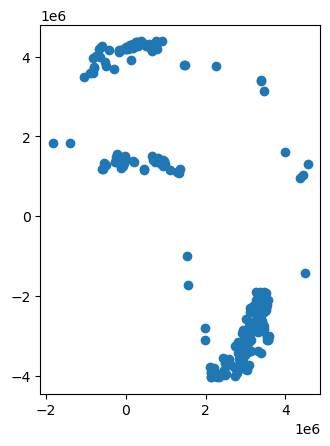

In [167]:
# Define the layers
layers = ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']

# Create a dictionary to hold the GeoDataFrames
layer_dam_gdfs = {}

# Iterate through the layers and load the corresponding shapefiles
for layer in layers:
    dam_shp_path = resolve_path(config[f'Africa_Dam_{layer}_shp_path'])
    gdf = gpd.read_file(dam_shp_path)
    gdf.set_crs("EPSG:4326")
    gdf = gdf.to_crs("EPSG:3857")
    print(gdf.head())
    gdf.plot()
    plt.show()
    layer_dam_gdfs[layer] = gdf


Load Layered Irrigation data

In [168]:
# Define the layers
layers = ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']

# Create a dictionary to hold the GeoDataFrames
layer_AEI_gdfs = {}

# Iterate through the layers and load the corresponding shapefiles
for layer in layers:
    shp_path = resolve_path(config[f'{layer}_AEI_2015_shp_path'])
    layer_AEI_gdfs[layer] = gpd.read_file(shp_path)


Load, Reproject, Save CPIS data

In [169]:
# Define the aridity layers
layers = ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']

# Create a dictionary to hold the CPIS GeoDataFrames for each layer
layer_cpis_gdfs = {}

# Load the CPIS GeoDataFrames into the dictionary
for layer in tqdm(layers, desc="Loading CPIS Layers"):
    shp_path = resolve_path(config[f'Combined_CPIS_{layer}_shp_path'])
    layer_cpis_gdfs[layer] = gpd.read_file(shp_path)
    print(f"Loaded {layer} CPIS GeoDataFrame with CRS: {layer_cpis_gdfs[layer].crs}")

Loading CPIS Layers:   0%|          | 0/4 [00:00<?, ?it/s]

Loading CPIS Layers:  25%|██▌       | 1/4 [00:03<00:11,  3.74s/it]

Loaded Semi_Arid CPIS GeoDataFrame with CRS: EPSG:3857


Loading CPIS Layers:  50%|█████     | 2/4 [00:04<00:04,  2.15s/it]

Loaded Arid CPIS GeoDataFrame with CRS: EPSG:3857


Loading CPIS Layers:  75%|███████▌  | 3/4 [00:05<00:01,  1.36s/it]

Loaded Hyper_Arid CPIS GeoDataFrame with CRS: EPSG:3857


Loading CPIS Layers: 100%|██████████| 4/4 [00:10<00:00,  2.70s/it]

Loaded All CPIS GeoDataFrame with CRS: EPSG:3857


Load, Reproject, Save country data

EPSG:4326
EPSG:3857


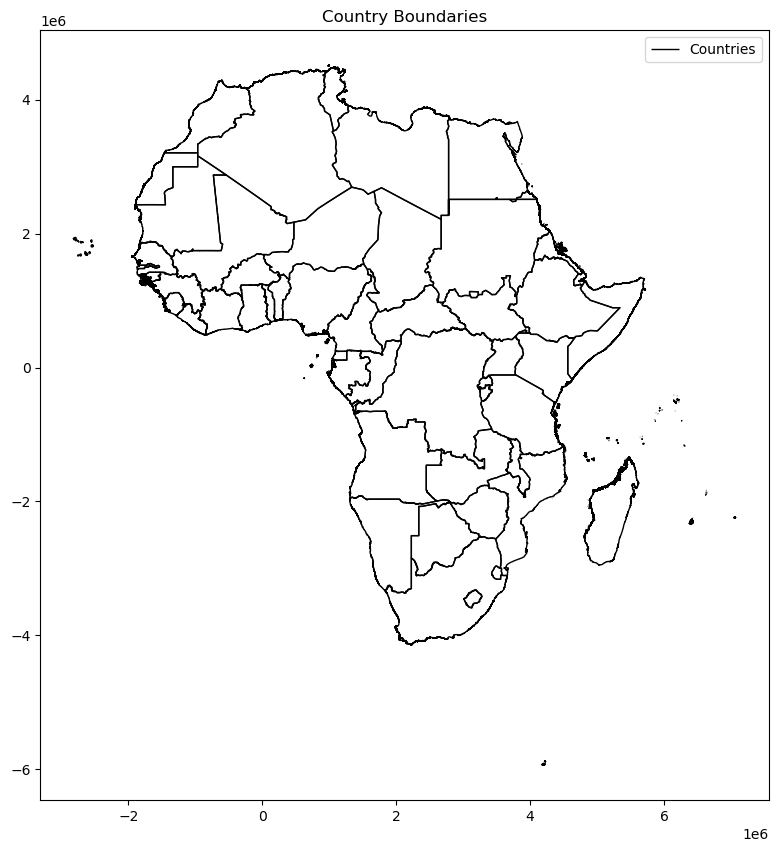

In [170]:
# Load the country shapefile and reproject
gdf_countries_deg = gpd.read_file(resolve_path(config['Africa_Countries_shp_path']))
print(gdf_countries_deg.crs)
gdf_countries_reproj = gdf_countries_deg.to_crs("EPSG:3857")
print(gdf_countries_reproj.crs)

# Save the reprojected country data
gdf_countries_reproj.to_file(resolve_path(config['Africa_Countries_Reproj_shp_path']))

# Plot country boundaries
fig, ax = plt.subplots(figsize=(10, 10))
gdf_countries_reproj.boundary.plot(ax=ax, linewidth=1, edgecolor='black', label='Countries')
plt.title('Country Boundaries')
plt.legend()
plt.show()

Sort it by country

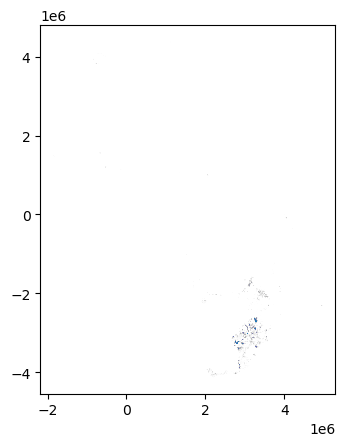

CPIS data for Semi_Arid layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Combined_CPIS_by_Country-shp/Combined_CPIS_Semi_Arid_by_Country.shp.


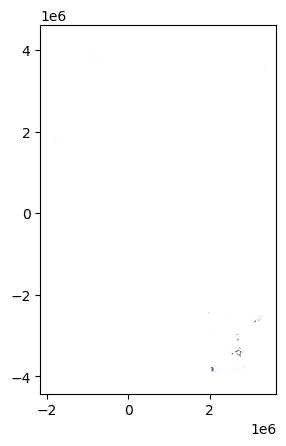

CPIS data for Arid layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Combined_CPIS_by_Country-shp/Combined_CPIS_Arid_by_Country.shp.


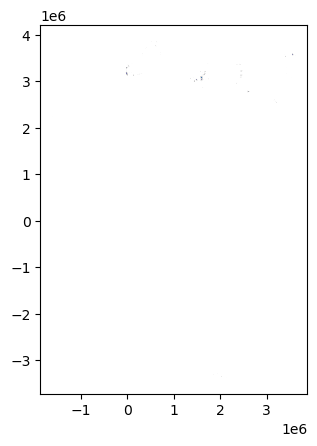

CPIS data for Hyper_Arid layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Combined_CPIS_by_Country-shp/Combined_CPIS_Hyper_Arid_by_Country.shp.


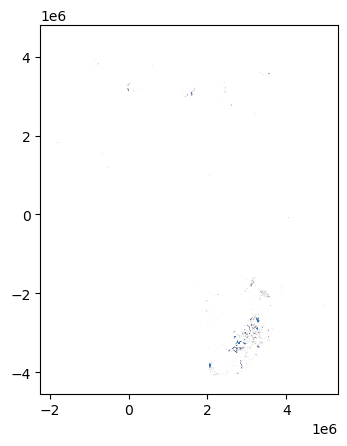

CPIS data for All layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Combined_CPIS_by_Country-shp/Combined_CPIS_All_by_Country.shp.


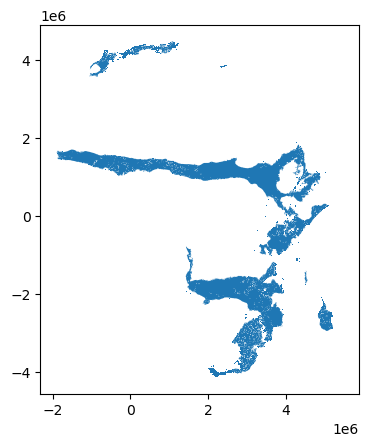

AEI data for Semi_Arid layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_by_Country-shp/G_AEI_2015_Semi_Arid_by_Country.shp.


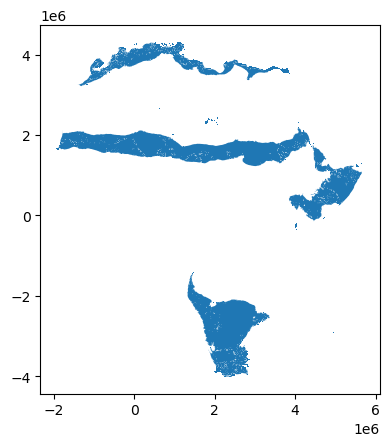

AEI data for Arid layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_by_Country-shp/G_AEI_2015_Arid_by_Country.shp.


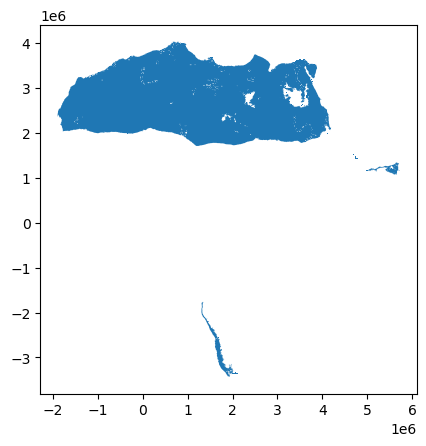

AEI data for Hyper_Arid layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_by_Country-shp/G_AEI_2015_Hyper_Arid_by_Country.shp.


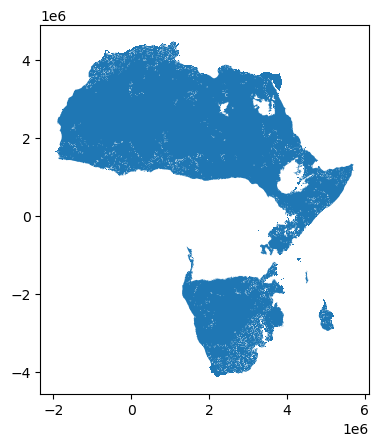

AEI data for All layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_by_Country-shp/G_AEI_2015_All_by_Country.shp.


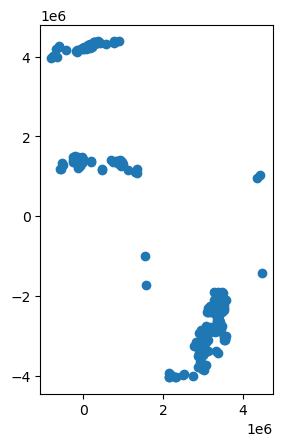

Dam data for Semi_Arid layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Africa_Dam_by_Country-shp/Africa_Semi_Arid_Dam_by_Country.shp.


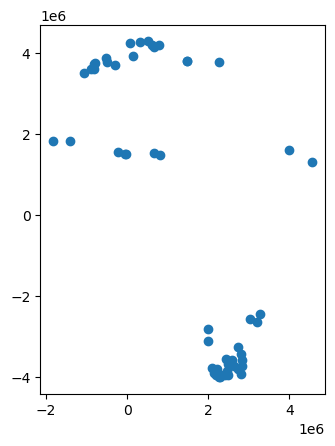

Dam data for Arid layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Africa_Dam_by_Country-shp/Africa_Arid_Dam_by_Country.shp.


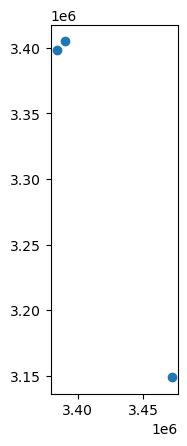

Dam data for Hyper_Arid layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Africa_Dam_by_Country-shp/Africa_Hyper_Arid_Dam_by_Country.shp.


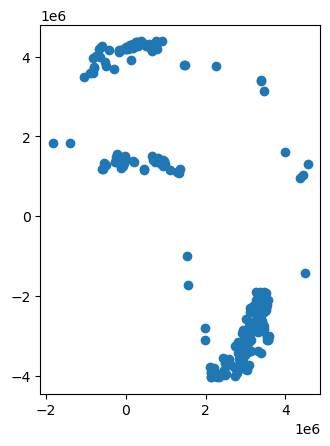

Dam data for All layer spatially joined, updated, and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Africa_Dam_by_Country-shp/Africa_All_Dam_by_Country.shp.


In [171]:

# Define a function to perform spatial join, keep necessary columns, and save the result
def perform_spatial_join_and_save(gdf, gdf_countries, output_path, include_raster_val=False):

    # Check if 'ISO3' is in the gdf_countries columns before the join
    if 'ISO3' not in gdf_countries.columns:
        print(f"Error: 'ISO3' column is missing in the countries GeoDataFrame.")
        return None

    # Check if the necessary columns are in the gdf being joined
    required_columns = ['geometry']
    if include_raster_val:
        required_columns.append('raster_val')
    
    for col in required_columns:
        if col not in gdf.columns:
            print(f"Error: '{col}' column is missing in the input GeoDataFrame.")
            return None

    # Perform spatial join
    joined_gdf = gpd.sjoin(gdf, gdf_countries[['ISO3', 'geometry']], how='left', predicate='within')
    
    # Use the 'ISO3_right' column from the country data and drop 'ISO3_left'
    if 'ISO3_right' in joined_gdf.columns:
        joined_gdf = joined_gdf.rename(columns={'ISO3_right': 'ISO3'})
        joined_gdf = joined_gdf.drop(columns=['ISO3_left', 'index_right'], errors='ignore')
    elif 'ISO3' not in joined_gdf.columns:
        print(f"Warning: 'ISO3' column is missing after the join for {output_path}")
        print("Available columns after join:", joined_gdf.columns)
        return None
    
    # Keep necessary columns
    if include_raster_val and 'raster_val' in gdf.columns:
        joined_gdf = joined_gdf[['geometry', 'raster_val', 'ISO3']]
    else:
        joined_gdf = joined_gdf[['geometry', 'ISO3']]
    
    # Save the joined GeoDataFrame to a shapefile
    joined_gdf.to_file(output_path, driver='ESRI Shapefile')
    
    joined_gdf.plot()
    plt.show()

    return joined_gdf

# Update the CPIS dictionary with joined data and save each one
for layer, gdf in layer_cpis_gdfs.items():
    output_path = resolve_path(config[f'Combined_CPIS_{layer}_by_Country_shp_path'])
    result = perform_spatial_join_and_save(gdf, gdf_countries_reproj, output_path)
    if result is not None:
        layer_cpis_gdfs[layer] = result
        print(f"CPIS data for {layer} layer spatially joined, updated, and saved to {output_path}.")
    else:
        print(f"Skipping saving for {layer} due to missing required columns or join issues.")

# Update the AEI dictionary with joined data and save each one
for layer, gdf in layer_AEI_gdfs.items():
    output_path = resolve_path(config[f'{layer}_AEI_2015_by_Country_shp_path'])
    result = perform_spatial_join_and_save(gdf, gdf_countries_reproj, output_path, include_raster_val=True)
    if result is not None:
        layer_AEI_gdfs[layer] = result
        print(f"AEI data for {layer} layer spatially joined, updated, and saved to {output_path}.")
    else:
        print(f"Skipping saving for {layer} due to missing required columns or join issues.")

# Update the Dam dictionary with joined data and save each one
for layer, gdf in layer_dam_gdfs.items():
    output_path = resolve_path(config[f'Dam_{layer}_by_Country_shp_path'])
    result = perform_spatial_join_and_save(gdf, gdf_countries_reproj, output_path)
    if result is not None:
        layer_dam_gdfs[layer] = result
        print(f"Dam data for {layer} layer spatially joined, updated, and saved to {output_path}.")
    else:
        print(f"Skipping saving for {layer} due to missing required columns or join issues.")


Calculate Sum of Distances from each CPIS to point to the Nearest Dam

In [172]:
def sum_distance_to_nearest(src_gdf, target_gdf):
    src_points = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if len(target_points) == 0:
        return 0  # Return 0 if there are no target points to avoid errors
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_points, k=1)
    
    return np.sum(dists)

# Initialize a dictionary to store results
sum_distances_by_layer = {}

# Iterate over each layer and calculate the sum of distances
for layer in ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']:
    # Load the CPIS and Dam GeoDataFrames for the current layer
    gdf_cpis = layer_cpis_gdfs[layer]
    gdf_dams = layer_dam_gdfs[layer]
    
    # Calculate the sum of distances for CPIS to nearest dam
    sum_distances = sum_distance_to_nearest(gdf_cpis, gdf_dams)
    
    # Store the result in the dictionary
    sum_distances_by_layer[layer] = sum_distances
    
    # Print the result
    print(f"Sum of distances from CPIS to nearest dam for {layer} layer: {sum_distances}")


Sum of distances from CPIS to nearest dam for Semi_Arid layer: 1865153271.5341802
Sum of distances from CPIS to nearest dam for Arid layer: 738055120.5906521
Sum of distances from CPIS to nearest dam for Hyper_Arid layer: 5375467761.093199
Sum of distances from CPIS to nearest dam for All layer: 4098853842.8853474


Calculate Average Distance of All AEI to Nearest Dam for Each Country

In [173]:

def avg_distance_to_nearest_by_country(src_gdf, target_gdf):
    src_points = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if len(target_points) == 0:
        return np.nan  # Return NaN if there are no target points to avoid errors

    tree = cKDTree(target_points)
    dists, _ = tree.query(src_points, k=1)
    
    return np.mean(dists)

# Initialize a dictionary to store results by layer and country
avg_distances_by_layer_and_country = {}

# Iterate over each layer and calculate average distances by country
for layer in ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']:
    # Load the AEI and Dam GeoDataFrames for the current layer
    gdf_AEI = layer_AEI_gdfs[layer]
    gdf_dams = layer_dam_gdfs[layer]
    gdf_cpis = layer_cpis_gdfs[layer]  # Load the CPIS GeoDataFrame for counting purposes

    # Initialize a dictionary to store the average distances by country for this layer
    avg_distances_by_country = {}

    # Iterate over each unique ISO3 country code in the AEI GeoDataFrame
    for iso3 in gdf_AEI['ISO3'].unique():
        group = gdf_AEI[gdf_AEI['ISO3'] == iso3]
        dams_in_country = gdf_dams[gdf_dams['ISO3'] == iso3]

        # Calculate the average distance for this country
        avg_distance = avg_distance_to_nearest_by_country(group, dams_in_country)
        avg_distances_by_country[iso3] = avg_distance

    # Convert the dictionary to a pandas Series
    avg_distances_by_country = pd.Series(avg_distances_by_country)

    # Drop NaN values from the Series before printing
    avg_distances_by_country_clean = avg_distances_by_country.dropna()

    # Count the number of CPIS and dams by country
    cpis_count_by_country = gdf_cpis['ISO3'].value_counts()
    dams_count_by_country = gdf_dams['ISO3'].value_counts()

    # Store the result in the main dictionary
    avg_distances_by_layer_and_country[layer] = avg_distances_by_country_clean
    
    # Print the result for this layer without NaN values
    print(f"\nAverage distances by country for AEI to nearest dam in {layer} layer (excluding NaNs):")
    print(avg_distances_by_country_clean)

    # Print the count of CPIS and dams for each country
    print(f"\nCounts of CPIS and dams by country in {layer} layer:")
    for iso3 in avg_distances_by_country_clean.index:
        print(f"Country: {iso3}, CPIS count: {cpis_count_by_country.get(iso3, 0)}, Dam count: {dams_count_by_country.get(iso3, 0)}")



Average distances by country for AEI to nearest dam in Semi_Arid layer (excluding NaNs):
DZA     49500.980042
MAR    114951.896859
ETH    266109.204264
BFA     86804.204150
NGA     87881.773152
GHA     84079.279703
AGO    160509.590199
MOZ    448375.001369
ZWE     34678.121335
ZAF     63557.910410
SWZ     26449.479908
LSO     64002.188466
dtype: float64

Counts of CPIS and dams by country in Semi_Arid layer:
Country: DZA, CPIS count: 0, Dam count: 31
Country: MAR, CPIS count: 68, Dam count: 7
Country: ETH, CPIS count: 0, Dam count: 2
Country: BFA, CPIS count: 35, Dam count: 30
Country: NGA, CPIS count: 1, Dam count: 24
Country: GHA, CPIS count: 3, Dam count: 1
Country: AGO, CPIS count: 34, Dam count: 2
Country: MOZ, CPIS count: 84, Dam count: 2
Country: ZWE, CPIS count: 1843, Dam count: 64
Country: ZAF, CPIS count: 18638, Dam count: 69
Country: SWZ, CPIS count: 162, Dam count: 6
Country: LSO, CPIS count: 3, Dam count: 2

Average distances by country for AEI to nearest dam in Arid laye

Calculate the Targeting Ratio

In [175]:
# Initialize a dictionary to store targeting ratios by layer
targeting_ratios_by_layer = {}

# Iterate over each layer to calculate the targeting ratio
for layer in ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']:
    # Retrieve the necessary data for the current layer
    sum_distances_cpis = sum_distances_by_layer[layer]
    avg_distances_AEI_by_country = avg_distances_by_layer_and_country[layer]
    
    # Count the number of CPIS in each country for the current layer
    cpis_count_by_country = layer_cpis_gdfs[layer]['ISO3'].value_counts()
    
    # Check both series contain the same countries and exclude those with zero values
    common_iso3 = cpis_count_by_country.index.intersection(avg_distances_AEI_by_country.index)
    common_iso3 = common_iso3[(cpis_count_by_country[common_iso3] > 0) & (avg_distances_AEI_by_country[common_iso3] > 0)]
    
    # Calculate the denominator
    denominator = sum(cpis_count_by_country[iso3] * avg_distances_AEI_by_country[iso3] for iso3 in common_iso3)
    
    # Avoid division by zero
    if denominator == 0:
        overall_targeting_ratio = float('inf')
    else:
        # Compute the targeting ratio
        overall_targeting_ratio = sum_distances_cpis / denominator
    
    # Store the targeting ratio for the current layer
    targeting_ratios_by_layer[layer] = overall_targeting_ratio
    
    # Print the targeting ratio for the current layer
    print(f"Targeting Ratio for {layer} layer: {overall_targeting_ratio}")
   


Targeting Ratio for Semi_Arid layer: 1.4267252350068964
Targeting Ratio for Arid layer: 1.1682372718925291
Targeting Ratio for Hyper_Arid layer: 115.36233747987498
Targeting Ratio for All layer: 1.5118771637495259


Calculate Targeting Ratio by Layer at Different Thresholds


Processing layer: Semi_Arid


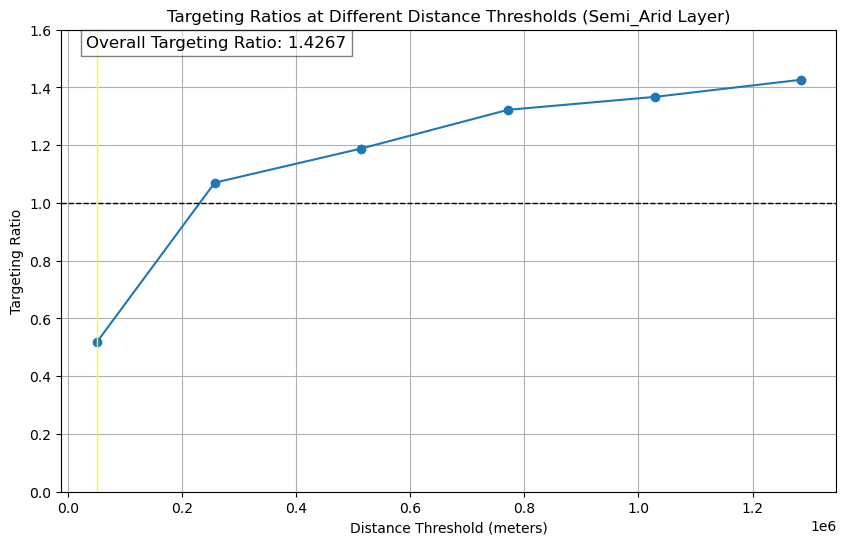


Processing layer: Arid


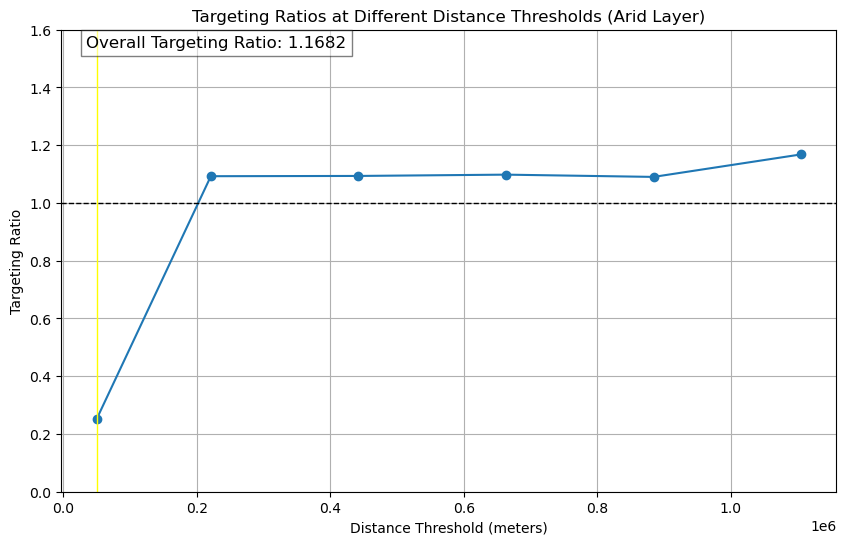


Processing layer: Hyper_Arid


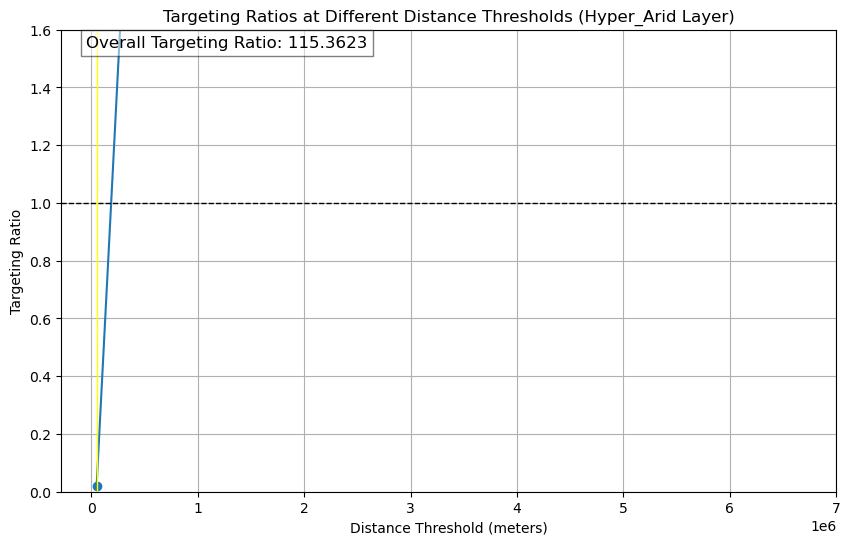


Processing layer: All


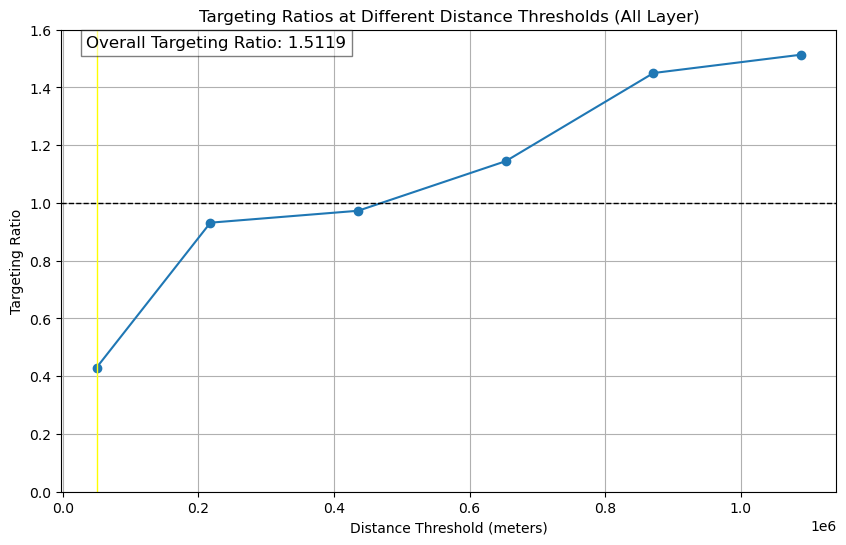

In [176]:

# Function to calculate distances to nearest target
def calculate_distances(src_gdf, target_gdf):
    src_centroids = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if target_points.shape[0] == 0 or src_centroids.shape[0] == 0:
        return np.array([])  # Return empty array if there are no points
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_centroids, k=1)
    
    return dists

# Iterate over each layer and calculate targeting ratios
targeting_ratios_thresholds_by_layer = {}

for layer in ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']:
    print(f"\nProcessing layer: {layer}")
    
    # Load the CPIS and Dam GeoDataFrames for the current layer
    gdf_cpis = layer_cpis_gdfs[layer]
    gdf_dams = layer_dam_gdfs[layer]
    gdf_AEI = layer_AEI_gdfs[layer]

    # Calculate distances for CPIS to nearest dam
    distances_cpis_to_dams = calculate_distances(gdf_cpis, gdf_dams)

    # Compute the maximum distance
    max_distance = np.max(distances_cpis_to_dams)

    # Create 5 thresholds
    thresholds = np.linspace(0, max_distance, 6)[1:]  

    # Add another at 50,000 meters
    thresholds = np.insert(thresholds, 0, 50000)

    # Calculate the targeting ratio for each threshold
    targeting_ratios = []

    for threshold in thresholds:
        
        # Filter distances from CPIS to nearest dam
        filtered_distances_cpis = distances_cpis_to_dams[distances_cpis_to_dams <= threshold]
        sum_distances_cpis = np.sum(filtered_distances_cpis)

        # Dict to store average distances by country
        avg_distances_AEI_by_country = {}

        # Iterate over each country in the AEI DataFrame
        for iso3, group in gdf_AEI.groupby('ISO3'):

            # Filter the dams to only those in the same country
            dams_in_country = gdf_dams[gdf_dams['ISO3'] == iso3]
            if len(dams_in_country) == 0:
                avg_distances_AEI_by_country[iso3] = np.nan
                continue
            
            # Calculate distances for AEI points to nearest dam in the same country
            distances = calculate_distances(group, dams_in_country)
            filtered_distances = distances[distances <= threshold]
            if len(filtered_distances) > 0:
                avg_distances_AEI_by_country[iso3] = np.mean(filtered_distances)
            else:
                avg_distances_AEI_by_country[iso3] = np.nan

        # Convert list to Series and drop NaNs
        avg_distances_AEI_by_country = pd.Series(avg_distances_AEI_by_country, index=gdf_AEI['ISO3'].unique()).dropna()

        # Count the number of CPIS in each country
        cpis_count_by_country = gdf_cpis['ISO3'].value_counts()

        # Ensure that both series contain the same countries
        common_iso3 = cpis_count_by_country.index.intersection(avg_distances_AEI_by_country.index)

        # Calculate the denominator
        denominator = sum(cpis_count_by_country[iso3] * avg_distances_AEI_by_country[iso3] for iso3 in common_iso3)

        # Compute the targeting ratio
        targeting_ratio = sum_distances_cpis / denominator if denominator != 0 else np.nan
        targeting_ratios.append(targeting_ratio)


    # Store the targeting ratios for the current layer
    targeting_ratios_thresholds_by_layer[layer] = (thresholds, targeting_ratios)


    # Plot targeting ratios at different thresholds for the current layer
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, targeting_ratios, marker='o', linestyle='-')
    plt.title(f'Targeting Ratios at Different Distance Thresholds ({layer} Layer)')
    plt.xlabel('Distance Threshold (meters)')
    plt.ylabel('Targeting Ratio')
    plt.ylim(0, 1.6)  # Set y-axis limits
    plt.grid(True)

    # Add horizontal line at y=1
    plt.axhline(y=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=50000, color='yellow', linestyle='-', linewidth=1)

    # Add text box with overall targeting ratio
    textstr = f'Overall Targeting Ratio: {targeting_ratios_by_layer[layer]:.4f}'
    plt.gcf().text(0.15, 0.85, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()



Generating plot for layer: Semi_Arid


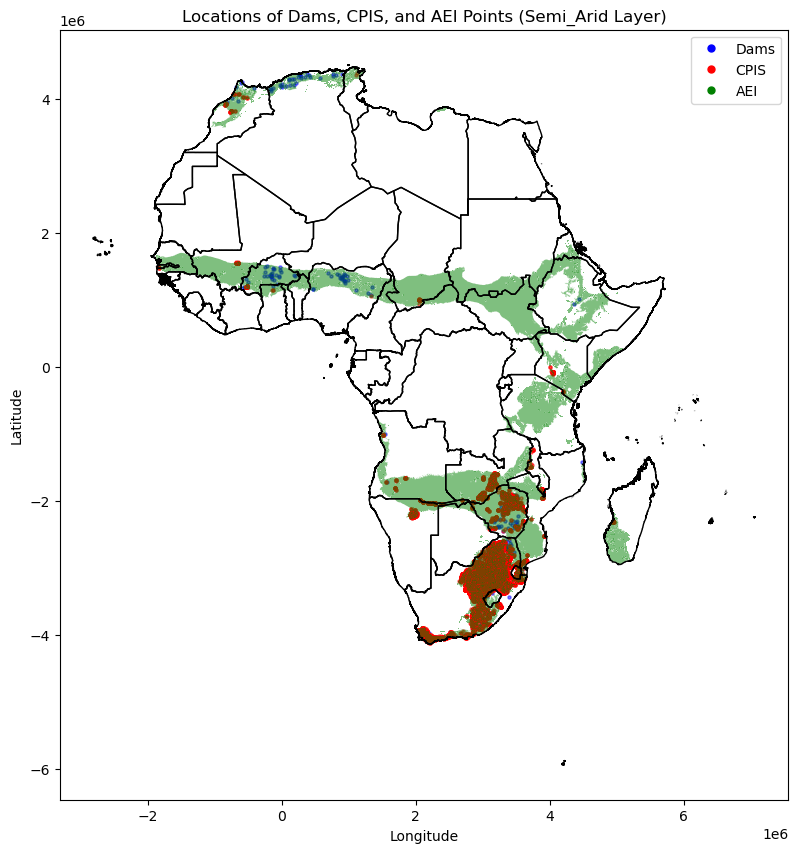


Generating plot for layer: Arid


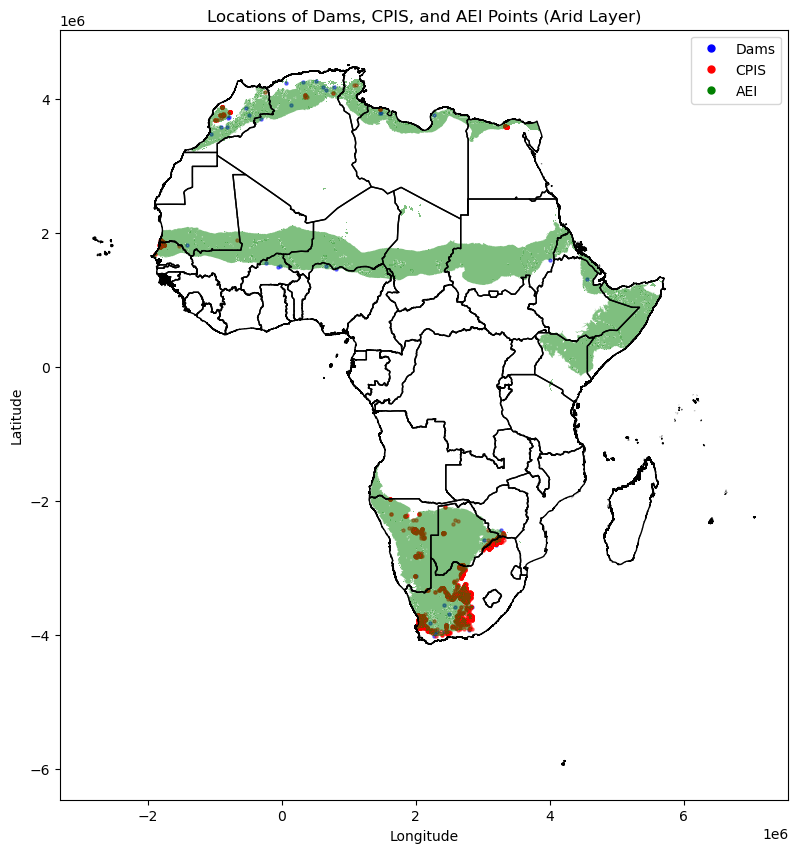


Generating plot for layer: Hyper_Arid


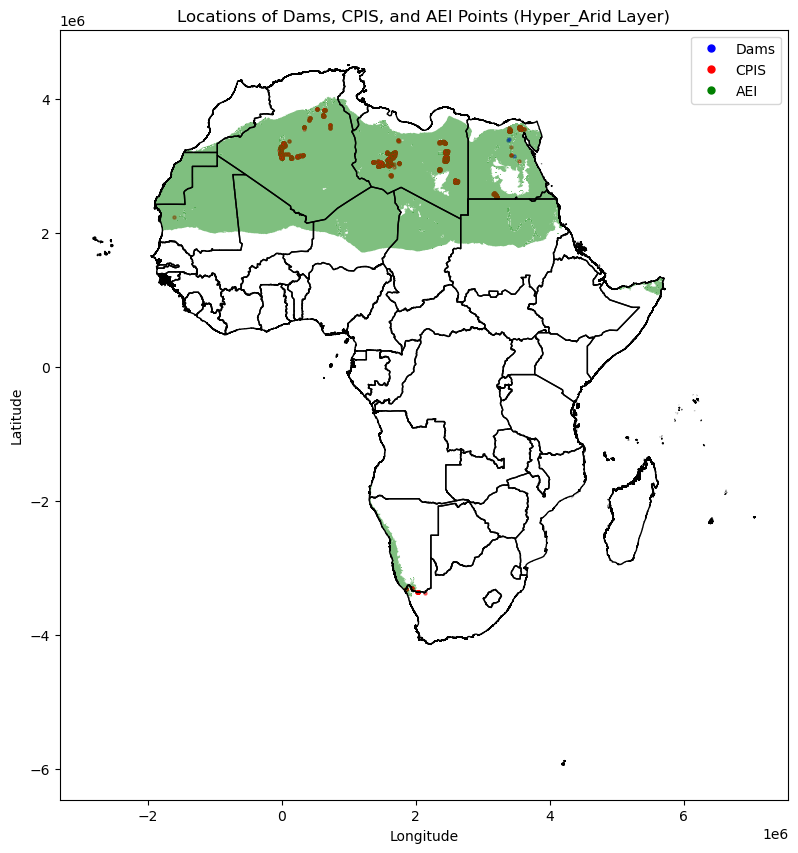


Generating plot for layer: All


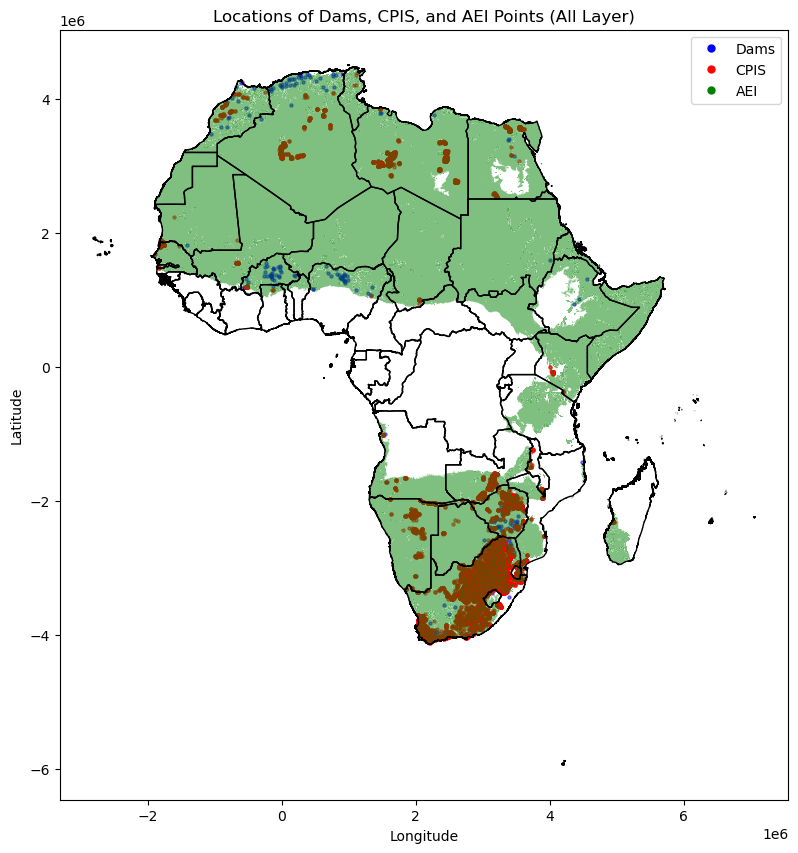

In [177]:
# Iterate over each layer to plot dams, CPIS, and AEI points
for layer in ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']:
    print(f"\nGenerating plot for layer: {layer}")
    
    # Load the CPIS, Dam, and AEI GeoDataFrames for the current layer
    gdf_cpis = layer_cpis_gdfs[layer]
    gdf_dams = layer_dam_gdfs[layer]
    gdf_AEI = layer_AEI_gdfs[layer]

    # Create a plot for the current layer
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot country boundaries
    gdf_countries_reproj.boundary.plot(ax=ax, linewidth=1, color='black')

    # Plot dams
    gdf_dams.plot(ax=ax, markersize=5, color='blue', alpha=0.5)

    # Plot CPIS
    gdf_cpis.centroid.plot(ax=ax, markersize=5, color='red', alpha=0.5)

    # Plot AEI points
    gdf_AEI.plot(ax=ax, markersize=5, color='green', alpha=0.5)

    # Create custom legend handles
    dam_handle = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=5, label='Dams')
    cpis_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=5, label='CPIS')
    aei_handle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='AEI')

     # Add custom legend to the plot
    ax.legend(handles=[dam_handle, cpis_handle, aei_handle])

    # Add title and labels
    ax.set_title(f'Locations of Dams, CPIS, and AEI Points ({layer} Layer)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Display the plot
    plt.show()


##### Consider Distribution of Distance Data


Generating histogram for layer: Semi_Arid


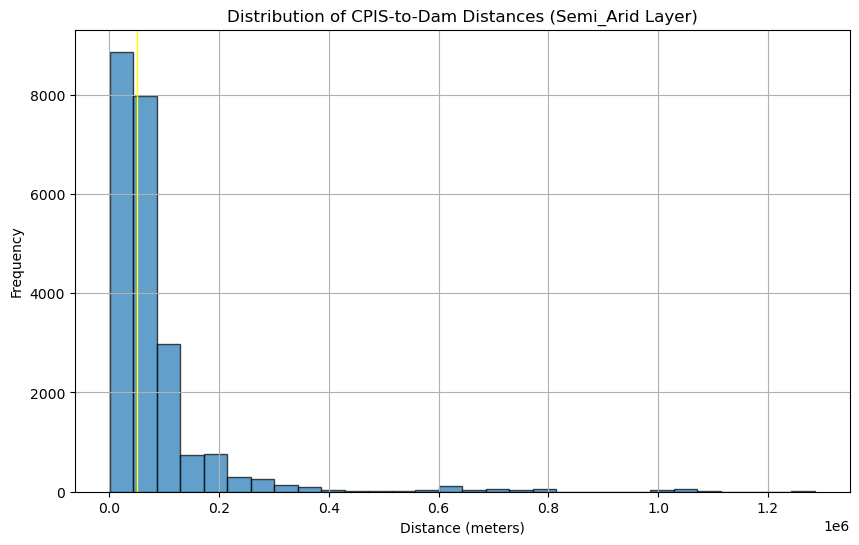


Generating histogram for layer: Arid


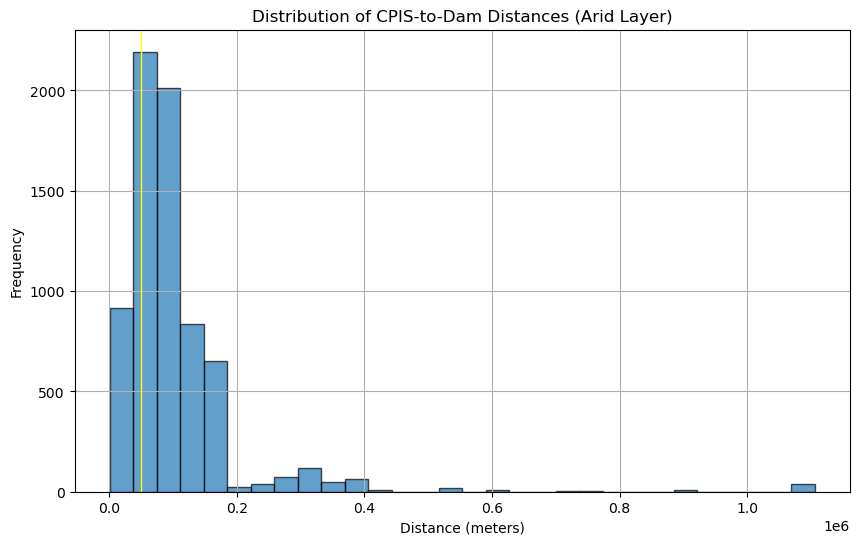


Generating histogram for layer: Hyper_Arid


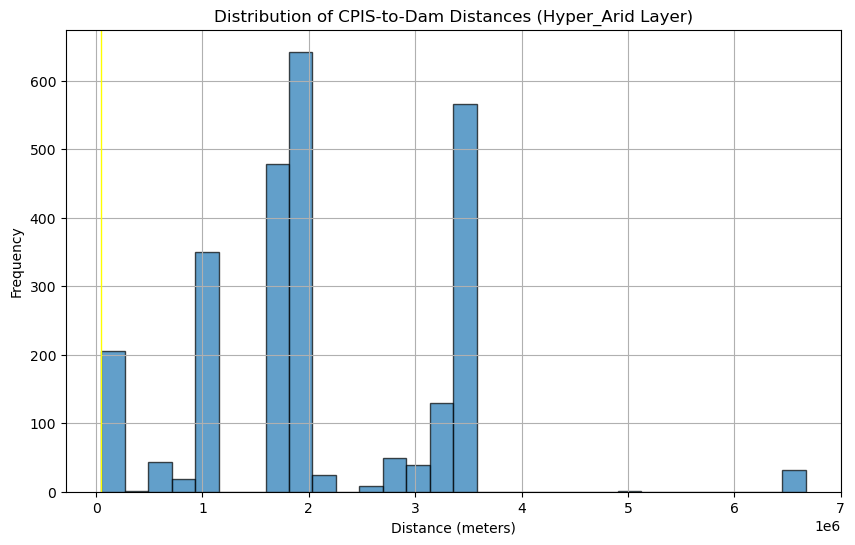


Generating histogram for layer: All


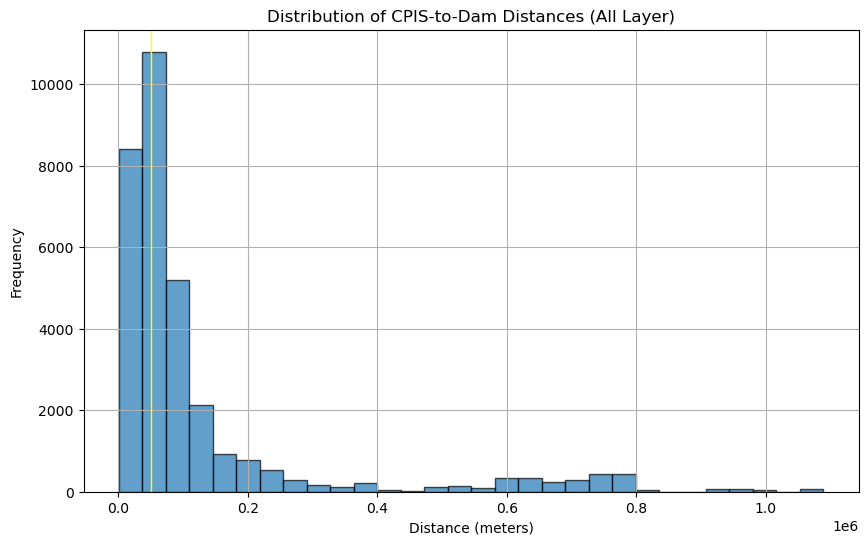

In [ ]:
# Iterate over each layer to plot histograms of CPIS-to-dam distances
for layer in ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']:
    print(f"\nGenerating histogram for layer: {layer}")
    
    # Load the CPIS and Dam GeoDataFrames for the current layer
    gdf_cpis = layer_cpis_gdfs[layer]
    gdf_dams = layer_dam_gdfs[layer]

    # Calculate distances for CPIS to nearest dam
    distances_cpis_to_dams = calculate_distances(gdf_cpis, gdf_dams)

    # Plot histogram of CPIS-to-dam distances
    plt.figure(figsize=(10, 6))
    plt.hist(distances_cpis_to_dams, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of CPIS-to-Dam Distances ({layer} Layer)')
    plt.xlabel('Distance (meters)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.axvline(x=50000, color='yellow', linestyle='-', linewidth=1)

    plt.show()



Processing layer: Semi_Arid


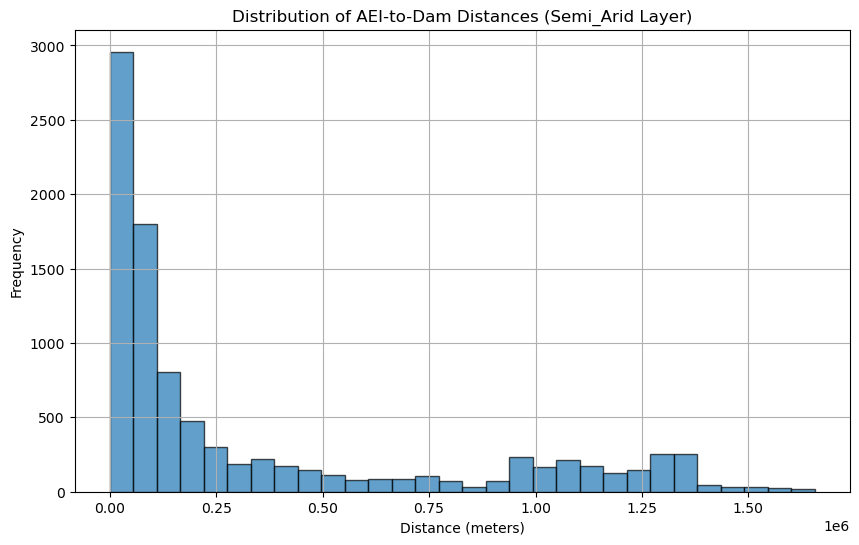


Processing layer: Arid


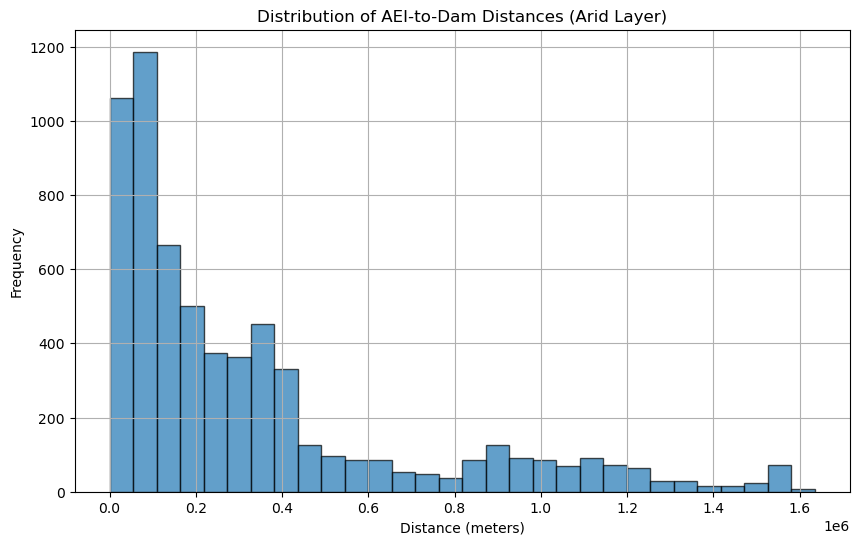


Processing layer: Hyper_Arid


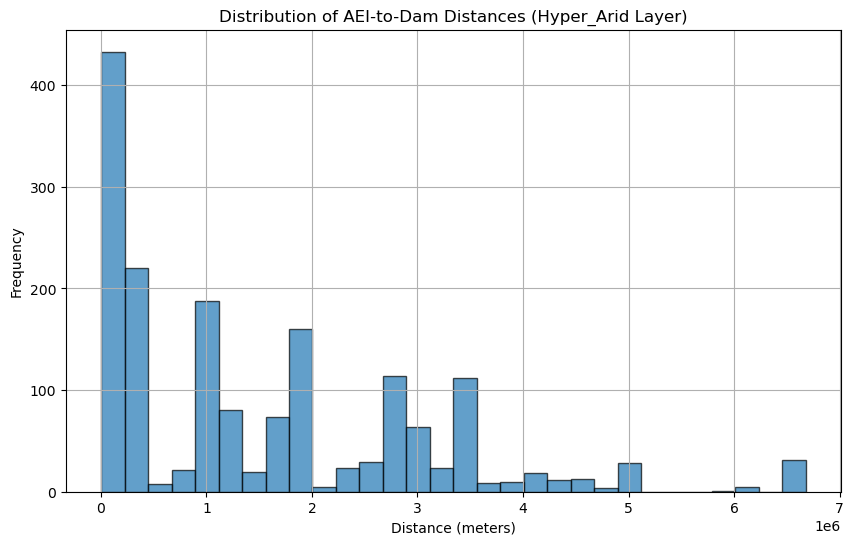


Processing layer: All


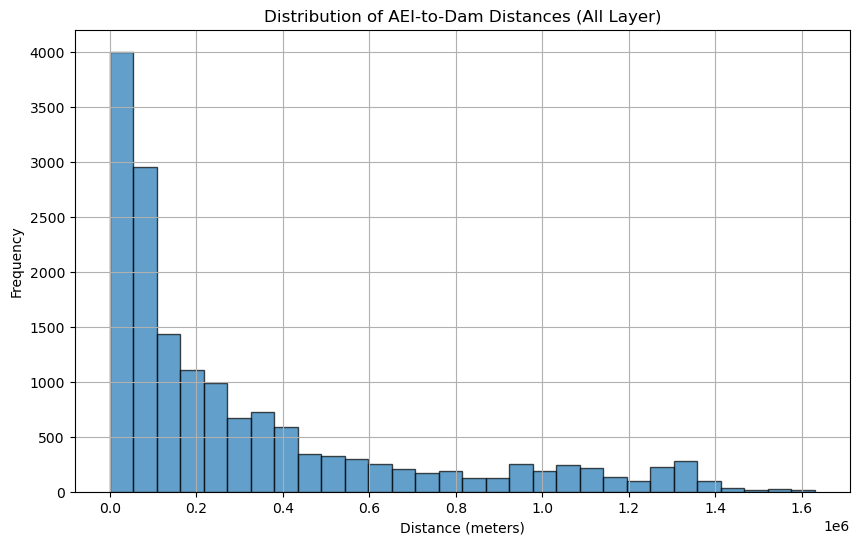

In [ ]:
# Function to calculate distances to nearest target
def calculate_distances(src_gdf, target_gdf):
    src_centroids = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if target_points.shape[0] == 0 or src_centroids.shape[0] == 0:
        return np.array([])  # Return empty array if there are no points
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_centroids, k=1)
    
    return dists

# Iterate over each layer to calculate AEI-to-dam distances and plot histograms
for layer in ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']:
    print(f"\nProcessing layer: {layer}")
    
    # Load the AEI and Dam GeoDataFrames for the current layer
    gdf_AEI = layer_AEI_gdfs[layer]
    gdf_dams = layer_dam_gdfs[layer]

    # Calculate distances for AEI points to the nearest dam
    distances_AEI_to_dams = calculate_distances(gdf_AEI, gdf_dams)

    # Plot histogram of AEI-to-dam distances
    plt.figure(figsize=(10, 6))
    plt.hist(distances_AEI_to_dams, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of AEI-to-Dam Distances ({layer} Layer)')
    plt.xlabel('Distance (meters)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
